## What's the point of a Multi-Armed Bandit?

Well, like many algorithms in machine learning, we use a multi-armed bandit to optimize our ability to select the best performing 'bandit' from a group of 'bandits'.

A pretty reasonable analogy is to consider yourself trying to choose the best slot-machine from a bank of slot machines? How would you go about learning which of the slots has the best payouts?

Here's a basic idea. Play each of the slots some number of games and record the results. Then, examine the results and continue to play the slot with the best payouts thus far.

If you've heard of A/B Testing, you probably realized that the above strategy is essentially just an A/B Test. First, we conducted *exploration*. During exploration, we try out the various options available to us (whether it be slot machines or website configurations) and record the results. Once we have conducted enough exploration, we can then switch to *explotation*. During explotation, we use the knowledge that we have gathered during exploration to choose the best-performing option.

However, when utilizing the multi-armed bandit we attempt to find the optimal balance between exploration and explotation. To optimize this balance, we want to minimize our *regret*. Regret is a measure of how often we chose to play an unoptimal bandit.

## Key Concepts

- Exploration
- Explotation
- Regret

## Creating the Bandits
Let's create a class to represent our bandits, and then create a list of bandits to play.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from random import uniform
from types import FunctionType
%matplotlib inline
sns.set_palette('colorblind')

class Bandit:
    
    def __init__(self, p=None):
        if p is None:
            self._p = uniform(0.2, .3)
        else:
            self._p = p
        self._results = []
    
    @property
    def p(self):
        return self._p
    
    def trial(self):
        self._results.append(uniform(0, 1) <= self.p)
    
    def trials(self, n):
        for trial in range(n):
            self.trial()
        return self.results
            
    @property
    def results(self):
        return np.array(self._results)
    
    def p_hat(self):
        return np.array(self.results).mean()
    
    def __repr__(self):
        return 'p = {:0.2f}'.format(self.p)
    
class MultiArmedBandit:

    def __init__(self, strategy:FunctionType, n_bandits=10):
        self.strategy = strategy
        self.n_bandits = n_bandits
        self.bandits = [Bandit() for n in range(n_bandits)]
            
    def __repr__(self):
        return 'Strategy: {}\nN_bandits: {}'.format(
            self.strategy.__name__, self.n_bandits)
    
    def trial(self):
        self.bandits[self.strategy(self.bandits)].trial()
        
    def conduct_trials(self, n_trials=10000):
        for trial in range(n_trials):
            self.trial()
            


## Strategy

Check out the [Multi-Armed Bandit Wikipedia page](https://en.wikipedia.org/wiki/Multi-armed_bandit) for more information about these strategies.

### Epsilon-Greedy

Let's start with a strategy called epsilon-greedy. In this strategy, we're going to choose a random bandit to play with a probability of $\epsilon$. The remainder of the time we will play the best bandit.

Essentially, we will *explore*  $\epsilon$ percent of trials and *exploit* the remainder of the time.

In [5]:
def epsilon_greedy_choice(
        bandits: list,
        epsilon: float=0.1):
    if uniform(0, 1) <= epsilon or np.array([bandit.results.shape[0] for bandit in bandits]).min() == 0:
        # avoids dividing by zero
        return np.random.randint(len(bandits))
    return np.array([bandit.p_hat() for bandit in bandits]).argmax()

eg_ma_bandit = MultiArmedBandit(epsilon_greedy_choice)
eg_ma_bandit.conduct_trials()
for bandit in eg_ma_bandit.bandits:
    print(bandit, '{:0.2f}'.format(bandit.results.mean()), bandit.results.shape[0])

p = 0.23 0.26 133
p = 0.24 0.22 86
p = 0.23 0.18 126
p = 0.29 0.30 356
p = 0.24 0.24 155
p = 0.21 0.19 88
p = 0.26 0.30 452
p = 0.23 0.23 105
p = 0.30 0.30 8299
p = 0.23 0.23 200


## Zero-Regret Strategies

## Sample Size Effect on Distribution of Sample Means

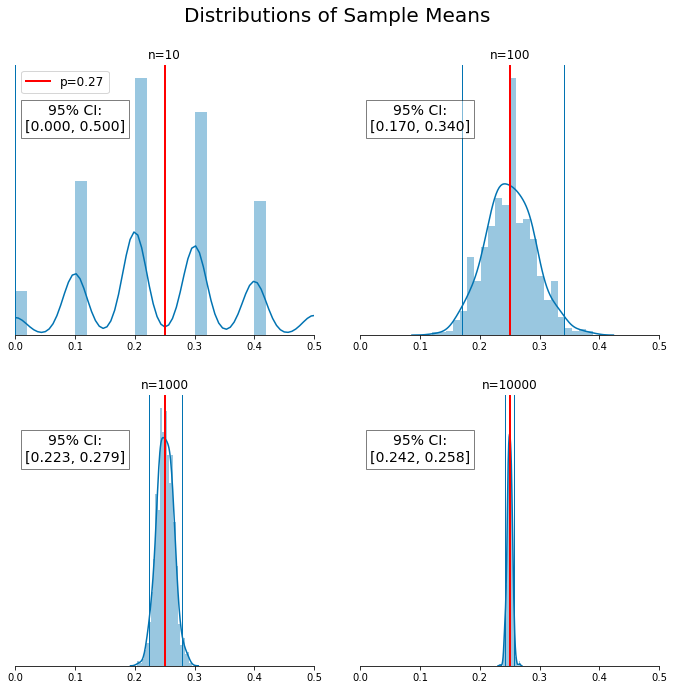

In [14]:
sample_sizes = [10, 100, 1000, 10000]
num_samples = 1000
p = 0.25
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for n, ax in zip(sample_sizes, axs.flatten()):
    means = np.array([Bandit(p).trials(n).mean() for sample in range(num_samples)])
    sns.distplot(means, ax=ax)
    ax.axvline(p, c='red', linewidth=2, label='p={:0.2f}'.format(bandits[0].p))
    lower_bound = np.percentile(means, 2.5)
    upper_bound = np.percentile(means, 97.5)
    ax.axvline(upper_bound, linewidth=1)
    ax.axvline(lower_bound, linewidth=1)
    ax.text(x=.20, y=.8, s='95% CI:\n[{:0.3f}, {:0.3f}]'.format(lower_bound, upper_bound),
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes,
            verticalalignment='center', horizontalalignment='center',
            fontsize=14)
    ax.set_xlim(0, .5)
    ax.set_yticks([])
    ax.set_ylabel(None)
    for spine in ax.spines:
        if spine != 'bottom':
            ax.spines[spine].set_visible(False)
    ax.set_title('n={}'.format(n))

fig.suptitle('Distributions of Sample Means', fontsize=20)
axs[0,0].legend(loc='upper left', fontsize=12)
plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.90)
plt.show()